In [2]:
import os
import argparse
import numpy as np
import pandas as pd
import datetime as dt

#bt_dir = '../adr_results/1400_1e-4_var_penalty_from_2021'
#bt_dir = '../adr_results/1e-4_all_europe_pos_constraint_1430_2pct_exclusions/'
bt_dir = '../adr_results/long_5e-2_pct_volume_unhedged/'
#bt_dir = '../adr_results/ohlcv_db_data/'

pnl = pd.read_csv(os.path.join(bt_dir, 'pnl.csv', ), index_col=0, parse_dates=True)
pnl.columns = ['pnl']
gmv = pd.read_csv(os.path.join(bt_dir, 'gmv.csv'), index_col=0, parse_dates=True)
gmv.columns = ['gmv']
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df['commission'] = 0.0006 * trade_df['size'].abs()
close_idx = trade_df['timestamp'].str[11:13] == '16'
trade_df.loc[close_idx, 'exchange_fee'] = 0.0016 * trade_df.loc[close_idx, 'size'].abs()
trade_df.loc[~close_idx, 'exchange_fee'] = -0.0018 * trade_df.loc[~close_idx, 'size'].abs()
# trade_df.loc[:,'exchange_fee'] = 0
# trade_df.loc[:,'commission'] = 0
trade_df['date'] = pd.to_datetime(trade_df['timestamp'].str[:10])

In [3]:
daily_fees = trade_df.groupby('date')[['commission', 'exchange_fee']].sum()
merged = pnl.merge(daily_fees, left_index=True, right_index=True)
merged['pnl_after_fees'] = merged['pnl'] - merged['commission'] - merged['exchange_fee']
merged = merged.merge(gmv, left_index=True, right_index=True)

In [4]:
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'], utc=True, format='mixed')
trades = trade_df.groupby(['timestamp','ticker']).last().reset_index()
trades['pos'] = trades.groupby('ticker')['size'].transform('cumsum')
pos = trades.pivot(index='timestamp',columns='ticker',values='pos').ffill().fillna(0)
price = trades.pivot(index='timestamp',columns='ticker',values='price').ffill().fillna(0)
all_gmv = (pos * price).abs().sum(axis=1).to_frame('gmv')
max_gmv = all_gmv.max()
all_gmv['date'] = all_gmv.index.date

Text(0.95, 0.7, 'Annualized PnL: 1,803,000\nMean GMV: $17,386,379\nAnnualized Return on Capital (15% haircut): 70.87%\nAnnualized Sharpe: 4.61\n')

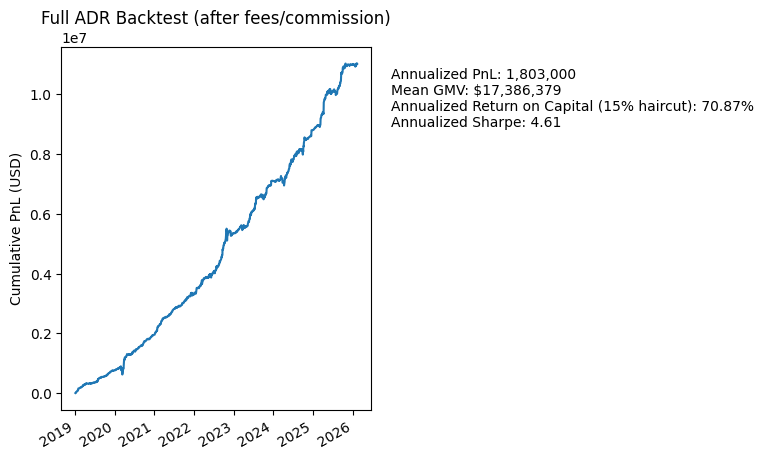

In [5]:
import matplotlib.pyplot as plt
#merged = merged.loc[:'2026-11-07']
#all_gmv = all_gmv.loc[:'2026-11-07']
gmv_merged = merged[['pnl_after_fees']].merge(all_gmv.loc['2019':'2026'].groupby('date')['gmv'].max().to_frame(name='gmv'), left_index=True, right_index=True)
ret = (gmv_merged['pnl_after_fees']/gmv_merged['gmv'])
annualized_ret = ret.mean() * 252 * 100/15


plt.figure(figsize=(4,4*1.333))
merged.loc['2019':'2026'].loc['2019':'2026', 'pnl_after_fees'].cumsum().plot()
plt.title('Full ADR Backtest (after fees/commission)')
plt.ylabel('Cumulative PnL (USD)')
# Displaying metrics in whitespace outside of plot, with commas as thousands separators:
plt.figtext(.95, 0.7, #f"Total PnL: ${merged.loc['2019':'2026']['pnl_after_fees'].sum().round(-3):,.0f}\n"
            f"Annualized PnL: {(252 * merged.loc['2019':'2026']['pnl_after_fees'].sum() / len(merged.loc['2019':'2026'])).round(-3):,.0f}\n"
             f"Mean GMV: ${gmv_merged['gmv'].mean():,.0f}\n"
            f"Annualized Return on Capital (15% haircut): {annualized_ret:.2%}\n"
            #f"Annualized Sharpe: {np.sqrt(252) * merged.loc['2019':'2026']['pnl_after_fees'].mean()/merged.loc['2019':'2026']['pnl_after_fees'].std():.2f}\n")
            f"Annualized Sharpe: {np.sqrt(252) * ret.mean()/ret.std():.2f}\n")

Text(0.95, 0.7, 'Total PnL: $827,000\nAnnualized PnL: 2,064,000\nAnnualized Return: 32.70%\nAnnualized Sharpe: 3.86\n')

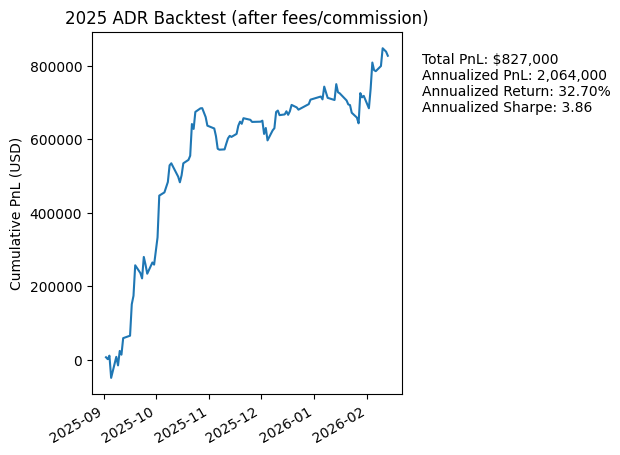

In [6]:
import matplotlib.pyplot as plt

#all_gmv = all_gmv.to_frame(name='gmv')
all_gmv['date'] = all_gmv.index.date
gmv_merged = merged[['pnl_after_fees']].merge(all_gmv.loc['2025-03-10':].groupby('date')['gmv'].max().to_frame(name='gmv'), left_index=True, right_index=True)
ret = (gmv_merged['pnl_after_fees']/gmv_merged['gmv'])
annualized_ret = (gmv_merged['pnl_after_fees']/gmv_merged['gmv']).mean() * 252 * 100/15

plt.figure(figsize=(4,4*1.333))
merged.loc['2025-03-10':, 'pnl_after_fees'].cumsum().plot()

plt.title('2025 ADR Backtest (after fees/commission)')
plt.ylabel('Cumulative PnL (USD)')
# Displaying metrics in whitespace outside of plot, with commas as thousands separators:
plt.figtext(.95, 0.7, f"Total PnL: ${merged.loc['2025-03-10':]['pnl_after_fees'].sum().round(-3):,.0f}\n"
                        f"Annualized PnL: {(252 * merged.loc['2025-03-10':]['pnl_after_fees'].sum() / len(merged.loc['2025-03-10':])).round(-3):,.0f}\n"
                        f"Annualized Return: {annualized_ret:.2%}\n"
                       #f"Annualized Sharpe: {np.sqrt(252) * merged.loc['2025-03-10':]['pnl_after_fees'].mean()/merged.loc['2025-03-10':]['pnl_after_fees'].std():.2f}\n")
                        f"Annualized Sharpe: {np.sqrt(252) * ret.mean()/ret.std():.2f}\n")

Text(0.95, 0.7, 'Total PnL: $604,000\nAnnualized PnL: 604,000\nAnnualized Return: 11.90%\nAnnualized Sharpe: 2.57\n')

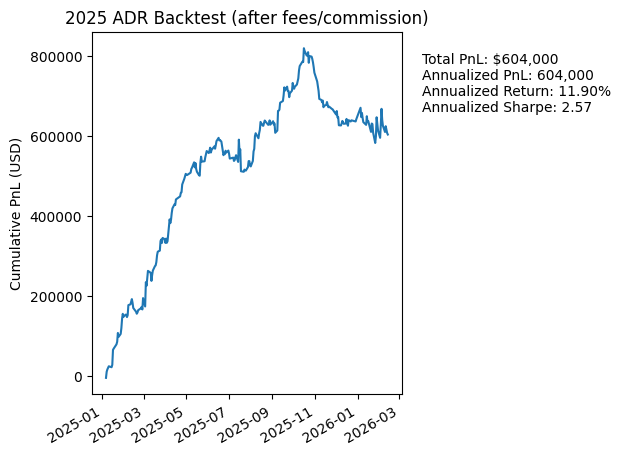

In [7]:
import matplotlib.pyplot as plt

#all_gmv = all_gmv.to_frame(name='gmv')
all_gmv['date'] = all_gmv.index.date
gmv_merged = merged[['pnl_after_fees']].merge(all_gmv.loc['2025':].groupby('date')['gmv'].max().to_frame(name='gmv'), left_index=True, right_index=True)
ret = (gmv_merged['pnl_after_fees']/gmv_merged['gmv'])
annualized_ret = (gmv_merged['pnl_after_fees']/gmv_merged['gmv']).mean() * 252 * 100/15

plt.figure(figsize=(4,4*1.333))
merged.loc['2025':, 'pnl_after_fees'].cumsum().plot()

plt.title('2025 ADR Backtest (after fees/commission)')
plt.ylabel('Cumulative PnL (USD)')
# Displaying metrics in whitespace outside of plot, with commas as thousands separators:
plt.figtext(.95, 0.7, f"Total PnL: ${merged.loc['2025':]['pnl_after_fees'].sum().round(-3):,.0f}\n"
                        f"Annualized PnL: {(252 * merged.loc['2025':]['pnl_after_fees'].sum() / len(merged.loc['2025':])).round(-3):,.0f}\n"
                        f"Annualized Return: {annualized_ret:.2%}\n"
                       #f"Annualized Sharpe: {np.sqrt(252) * merged.loc['2025':]['pnl_after_fees'].mean()/merged.loc['2025':]['pnl_after_fees'].std():.2f}\n")
                        f"Annualized Sharpe: {np.sqrt(252) * ret.mean()/ret.std():.2f}\n")

/tmp/ipykernel_882120/781648772.py:15: RuntimeWarning: invalid value encountered in scalar divide
  f"Annualized PnL: {(252 * merged.loc['2024':'2024']['pnl_after_fees'].sum() / len(merged.loc['2024':'2024'])).round(-3):,.0f}\n"


Text(0.95, 0.7, 'Total PnL: $0\nAnnualized PnL: nan\nAnnualized Return: nan%\nAnnualized Sharpe: nan\n')

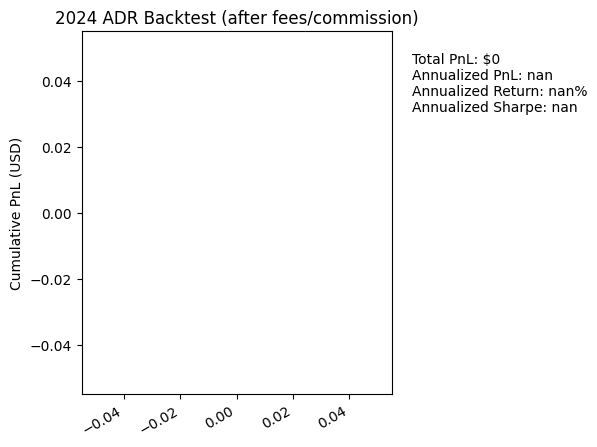

In [8]:
import matplotlib.pyplot as plt

#all_gmv = all_gmv.to_frame(name='gmv')
all_gmv['date'] = all_gmv.index.date
gmv_merged = pnl.merge(all_gmv.loc['2024':'2024'].groupby('date')['gmv'].max().to_frame(name='gmv'), left_index=True, right_index=True)
annualized_ret = (gmv_merged['pnl']/gmv_merged['gmv']).mean() * 252 * 100/15

plt.figure(figsize=(4,4*1.333))
merged.loc['2024':'2024', 'pnl_after_fees'].cumsum().plot()

plt.title('2024 ADR Backtest (after fees/commission)')
plt.ylabel('Cumulative PnL (USD)')
# Displaying metrics in whitespace outside of plot, with commas as thousands separators:
plt.figtext(.95, 0.7, f"Total PnL: ${merged.loc['2024':'2024']['pnl_after_fees'].sum().round(-3):,.0f}\n"
                    f"Annualized PnL: {(252 * merged.loc['2024':'2024']['pnl_after_fees'].sum() / len(merged.loc['2024':'2024'])).round(-3):,.0f}\n"
                    f"Annualized Return: {annualized_ret:.2%}\n"
                    f"Annualized Sharpe: {np.sqrt(252) * merged.loc['2024':'2024']['pnl_after_fees'].mean()/merged.loc['2024':'2024']['pnl_after_fees'].std():.2f}\n")

In [9]:
import os
import pandas as pd

price_filename = '../data/raw/adrs/adr_PX_LAST_adjust_none.csv'
etf_filename = '../data/raw/etfs/market/market_etf_PX_LAST_adjust_none.csv'
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'], utc=True)

price_df = pd.read_csv(price_filename, index_col=0, parse_dates=True)
etf_df = pd.read_csv(etf_filename, index_col=0, parse_dates=True)
price_df = pd.concat([price_df, etf_df], axis=1)
trade_df['date'] = trade_df['timestamp'].dt.date

position_df = trade_df[['date','ticker','size']].groupby(['date','ticker'])['size'].sum().unstack().fillna(0).cumsum()
notional_trade_df = trade_df.copy()
notional_trade_df['value'] = notional_trade_df['size'] * notional_trade_df['price']
notional_trade_df['abs_value'] = notional_trade_df['value'].abs()

cash_flow = -notional_trade_df.groupby(['date','ticker'])['value'].sum()

position_change = position_df.diff()
position_change.iloc[0] = position_df.iloc[0]
position_value = (position_df * price_df.loc[position_df.index, position_df.columns])

pnl = (position_value - position_value.shift(fill_value=0)) + cash_flow
gmv = position_value.abs()

In [10]:
by_ticker = cash_flow.unstack()
by_ticker.index = pd.to_datetime(by_ticker.index)

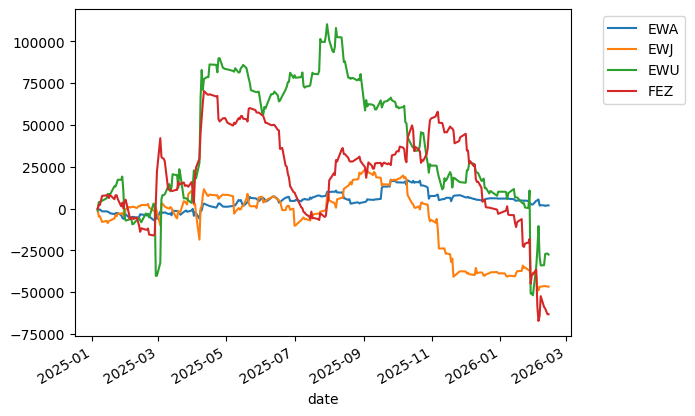

In [11]:
import matplotlib.pyplot as plt

#by_ticker[['SONY','TAK','TM','HMC','MUFG','SMFG','MFG','BHP','WDS','EWA','EWJ','EWU','FEZ']].loc['2025':].cumsum().plot()
by_ticker[['EWA','EWJ','EWU','FEZ']].loc['2025':].cumsum().plot()
# placing legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

<Axes: xlabel='date'>

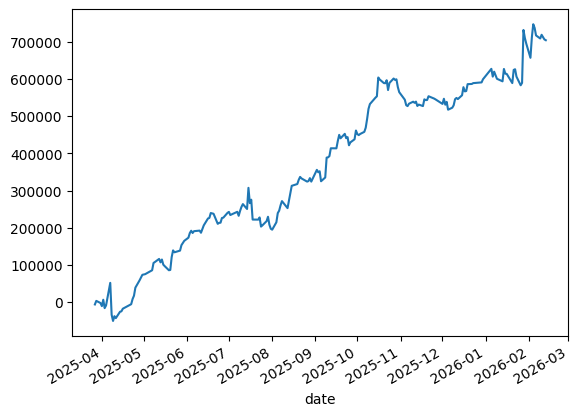

In [12]:
by_ticker[[c for c in by_ticker.columns if c not in ['EWA','EWJ','EWU','FEZ']]].sum(axis=1).iloc[-200:].cumsum().plot()

/tmp/ipykernel_882122/3679784615.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sign_df = open_df.pivot(index='date', columns='ticker', values='sign').fillna(0).astype(int)


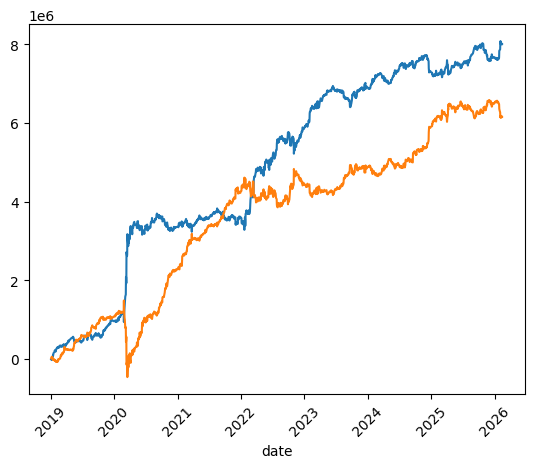

In [13]:
open_df = trade_df.sort_values('timestamp').groupby(['ticker','date']).first().reset_index()
open_df['val'] = open_df['size'] * open_df['price']
open_df['val'].sort_values()
close_df = trade_df.sort_values('timestamp').groupby(['ticker','date']).last().reset_index()
prices = close_df[['date','ticker','price']].merge(open_df[['date','ticker','price']], on=['date','ticker'], suffixes=('_close','_open'))
prices['date'] = pd.to_datetime(prices['date']).dt.strftime('%Y-%m-%d')
((prices['price_open'] - prices['price_close'])>0).sum()/len(prices)

open_df['sign']=(open_df['val']>0)
sign_df = open_df.pivot(index='date', columns='ticker', values='sign').fillna(0).astype(int)
long_pnl = (sign_df * by_ticker).sum(axis=1)
short_pnl = ((1-sign_df) * by_ticker).sum(axis=1)

long_pnl.cumsum().plot(label='Long PnL')
short_pnl.cumsum().plot(label='Short PnL')
plt.xticks(rotation=45);

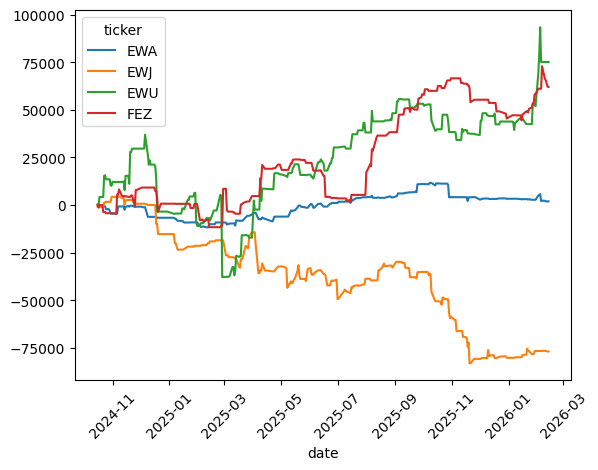

In [14]:
etf_tickers = ['EWA','EWJ','EWU','FEZ']
(sign_df * by_ticker)[etf_tickers].iloc[-300:].cumsum().plot()
plt.xticks(rotation=45);

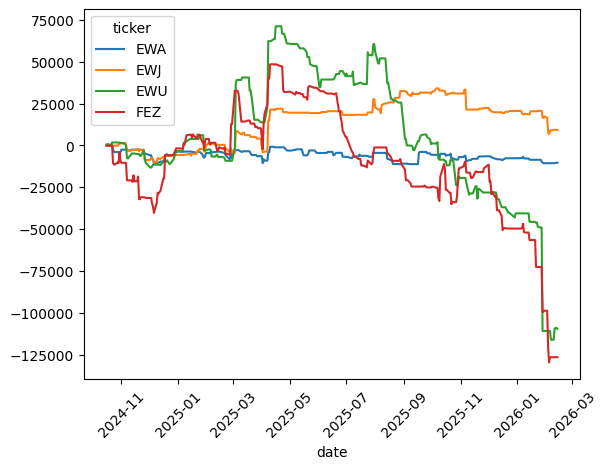

In [15]:
etf_tickers = ['EWA','EWJ','EWU','FEZ']
((1-sign_df) * by_ticker)[etf_tickers].iloc[-300:].cumsum().plot()
plt.xticks(rotation=45);

<Axes: xlabel='date'>

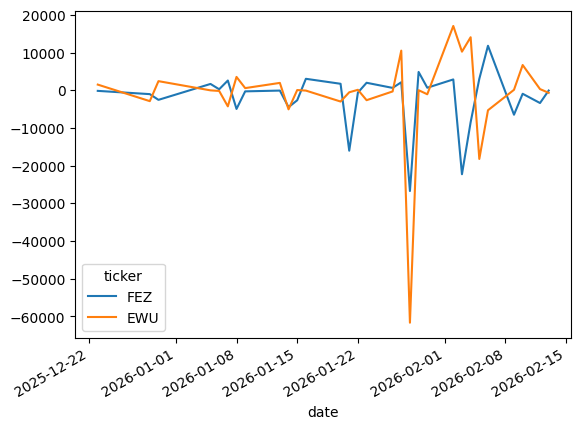

In [16]:
by_ticker[['FEZ','EWU']].iloc[-30:].plot()

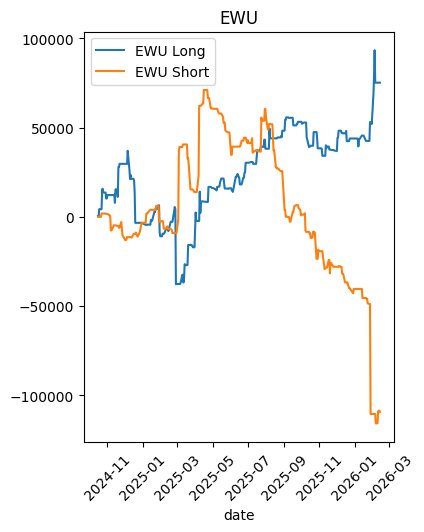

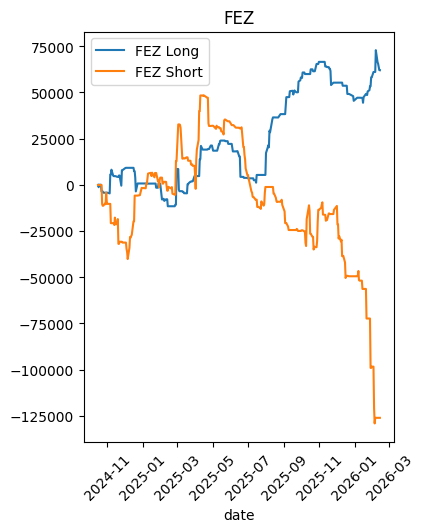

In [17]:
etf_tickers = ['EWA','EWJ','EWU','FEZ']
for ticker in ['EWU','FEZ']:#etf_tickers:
    plt.figure(figsize=(4,4*1.333))
    (sign_df[ticker] * by_ticker[ticker]).iloc[-300:].cumsum().plot(label=f'{ticker} Long')
    ((1-sign_df[ticker]) * by_ticker[ticker]).iloc[-300:].cumsum().plot(label=f'{ticker} Short')
    plt.xticks(rotation=45);
    plt.title(f'{ticker}')
    plt.legend()

<Axes: xlabel='date'>

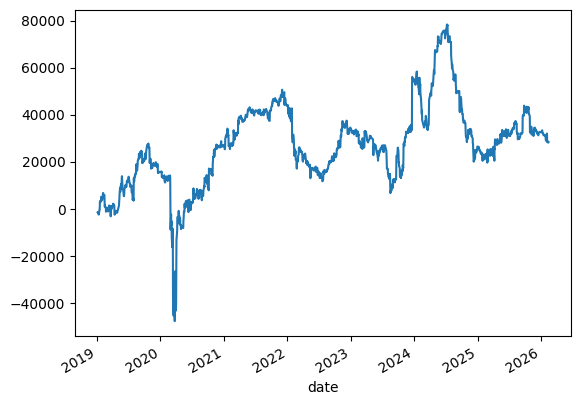

In [18]:
by_ticker['EWA'].cumsum().plot()

In [19]:
pnl = by_ticker[[c for c in by_ticker.columns if c not in ['EWA','EWJ','EWU','FEZ']]].sum(axis=1).to_frame()
pnl.columns = ['pnl']
gmv = notional_trade_df.groupby('date')['abs_value'].sum().to_frame() #pd.read_csv(os.path.join(bt_dir, 'gmv.csv'), index_col=0, parse_dates=True)
gmv.columns = ['gmv']
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df = trade_df[~trade_df['ticker'].isin(['EWA','EWJ','EWU','FEZ'])]
trade_df['commission'] = 0.0006 * trade_df['size'].abs()
close_idx = trade_df['timestamp'].str[11:13] == '16'
trade_df.loc[close_idx, 'exchange_fee'] = 0.0016 * trade_df.loc[close_idx, 'size'].abs()
trade_df.loc[~close_idx, 'exchange_fee'] = -0.0018 * trade_df.loc[~close_idx, 'size'].abs()
trade_df['date'] = pd.to_datetime(trade_df['timestamp'].str[:10])
daily_fees = trade_df.groupby('date')[['commission', 'exchange_fee']].sum()
merged = pnl.merge(daily_fees, left_index=True, right_index=True)
merged['pnl_after_fees'] = merged['pnl'] - merged['commission'] - merged['exchange_fee']
merged = merged.merge(gmv, left_index=True, right_index=True)

trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df = trade_df[~trade_df['ticker'].isin(['EWA','EWJ','EWU','FEZ'])]
trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'], utc=True, format='mixed')
trades = trade_df.groupby(['timestamp','ticker']).last().reset_index()
trades['pos'] = trades.groupby('ticker')['size'].transform('cumsum')
pos = trades.pivot(index='timestamp',columns='ticker',values='pos').ffill().fillna(0)
price = trades.pivot(index='timestamp',columns='ticker',values='price').ffill().fillna(0)
all_gmv = (pos * price).abs().sum(axis=1).to_frame('gmv')
max_gmv = all_gmv.max()
all_gmv['date'] = all_gmv.index.date

Text(0.95, 0.7, 'Total PnL: $208,000\nAnnualized PnL: 505,000\nAnnualized Return on Capital: 10.26%\nAnnualized Sharpe: 1.53\n')

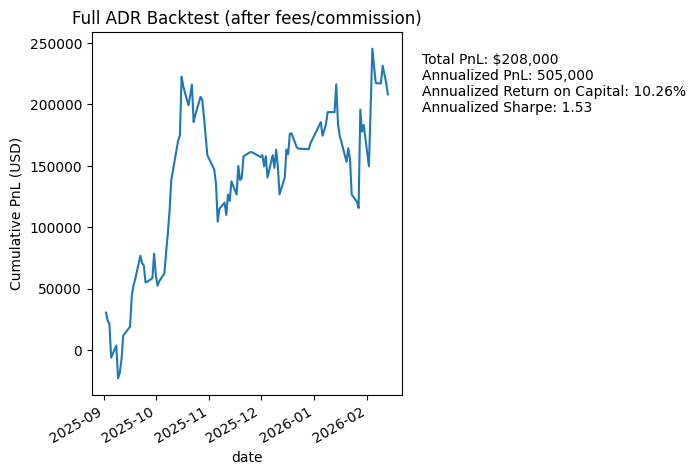

In [20]:
import matplotlib.pyplot as plt
#merged = merged.loc[:'2026-11-07']
#all_gmv = all_gmv.loc[:'2026-11-07']
gmv_merged = merged[['pnl_after_fees']].merge(all_gmv.loc['2019':'2026'].groupby('date')['gmv'].max().to_frame(name='gmv'), left_index=True, right_index=True)
ret = (gmv_merged['pnl_after_fees']/gmv_merged['gmv'])
annualized_ret = ret.mean() * 252 * 100/15


plt.figure(figsize=(4,4*1.333))
merged.loc['2019':'2026'].loc['2019':'2026', 'pnl_after_fees'].cumsum().plot()
plt.title('Full ADR Backtest (after fees/commission)')
plt.ylabel('Cumulative PnL (USD)')
# Displaying metrics in whitespace outside of plot, with commas as thousands separators:
plt.figtext(.95, 0.7, f"Total PnL: ${merged.loc['2019':'2026']['pnl_after_fees'].sum().round(-3):,.0f}\n"
            f"Annualized PnL: {(252 * merged.loc['2019':'2026']['pnl_after_fees'].sum() / len(merged.loc['2019':'2026'])).round(-3):,.0f}\n"
            f"Annualized Return on Capital: {annualized_ret:.2%}\n"
            #f"Annualized Sharpe: {np.sqrt(252) * merged.loc['2019':'2026']['pnl_after_fees'].mean()/merged.loc['2019':'2026']['pnl_after_fees'].std():.2f}\n")
            f"Annualized Sharpe: {np.sqrt(252) * ret.mean()/ret.std():.2f}\n")

Text(0.95, 0.7, 'Total PnL: $769,000\nAnnualized PnL: 769,000\nAnnualized Return on Capital: 18.50%\nAnnualized Sharpe: 2.70\n')

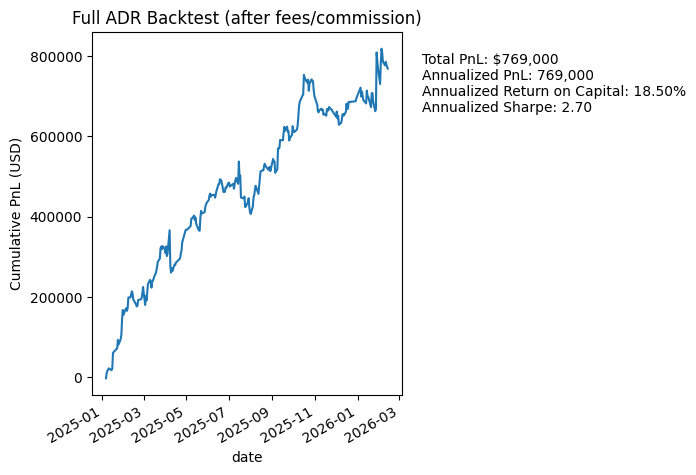

In [21]:
import matplotlib.pyplot as plt
#merged = merged.loc[:'2026-11-07']
#all_gmv = all_gmv.loc[:'2026-11-07']
gmv_merged = merged[['pnl_after_fees']].merge(all_gmv.loc['2025':'2026'].groupby('date')['gmv'].max().to_frame(name='gmv'), left_index=True, right_index=True)
ret = (gmv_merged['pnl_after_fees']/gmv_merged['gmv'])
annualized_ret = ret.mean() * 252 * 100/15


plt.figure(figsize=(4,4*1.333))
merged.loc['2025':'2026'].loc['2025':'2026', 'pnl_after_fees'].cumsum().plot()
plt.title('Full ADR Backtest (after fees/commission)')
plt.ylabel('Cumulative PnL (USD)')
# Displaying metrics in whitespace outside of plot, with commas as thousands separators:
plt.figtext(.95, 0.7, f"Total PnL: ${merged.loc['2025':'2026']['pnl_after_fees'].sum().round(-3):,.0f}\n"
            f"Annualized PnL: {(252 * merged.loc['2025':'2026']['pnl_after_fees'].sum() / len(merged.loc['2025':'2026'])).round(-3):,.0f}\n"
            f"Annualized Return on Capital: {annualized_ret:.2%}\n"
            #f"Annualized Sharpe: {np.sqrt(252) * merged.loc['2025':'2026']['pnl_after_fees'].mean()/merged.loc['2025':'2026']['pnl_after_fees'].std():.2f}\n")
            f"Annualized Sharpe: {np.sqrt(252) * ret.mean()/ret.std():.2f}\n")

Text(0.95, 0.7, 'Total PnL: $256,000\nAnnualized PnL: 619,000\nAnnualized Return on Capital: 12.52%\nAnnualized Sharpe: 1.65\n')

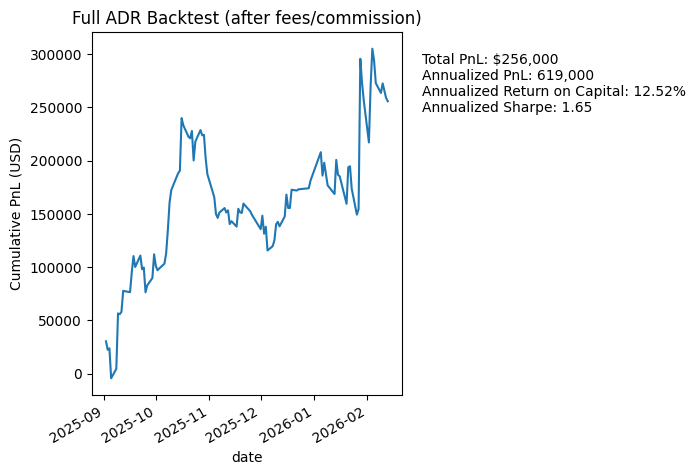

In [22]:
import matplotlib.pyplot as plt
#merged = merged.loc[:'2026-11-07']
#all_gmv = all_gmv.loc[:'2026-11-07']
gmv_merged = merged[['pnl_after_fees']].merge(all_gmv.loc['2025-09':'2026'].groupby('date')['gmv'].max().to_frame(name='gmv'), left_index=True, right_index=True)
ret = (gmv_merged['pnl_after_fees']/gmv_merged['gmv'])
annualized_ret = ret.mean() * 252 * 100/15


plt.figure(figsize=(4,4*1.333))
merged.loc['2025-09':'2026'].loc['2025-09':'2026', 'pnl_after_fees'].cumsum().plot()
plt.title('Full ADR Backtest (after fees/commission)')
plt.ylabel('Cumulative PnL (USD)')
# Displaying metrics in whitespace outside of plot, with commas as thousands separators:
plt.figtext(.95, 0.7, f"Total PnL: ${merged.loc['2025-09':'2026']['pnl_after_fees'].sum().round(-3):,.0f}\n"
            f"Annualized PnL: {(252 * merged.loc['2025-09':'2026']['pnl_after_fees'].sum() / len(merged.loc['2025-09':'2026'])).round(-3):,.0f}\n"
            f"Annualized Return on Capital: {annualized_ret:.2%}\n"
            #f"Annualized Sharpe: {np.sqrt(252) * merged.loc['2025-09':'2026']['pnl_after_fees'].mean()/merged.loc['2025-09':'2026']['pnl_after_fees'].std():.2f}\n")
            f"Annualized Sharpe: {np.sqrt(252) * ret.mean()/ret.std():.2f}\n")

In [27]:
stacked = by_ticker.loc['2025-09':].stack().reset_index().rename(columns={0:'pnl'})
stacked.loc[stacked['date']<'2025-10-15','group'] = 'pre'
stacked.loc[stacked['date']>='2025-10-15','group'] = 'post'

stacked.groupby(['ticker','group'])['pnl'].sum().unstack()[['pre','post']].sort_values('post')

group,pre,post
ticker,,
FEZ,21473.895,-112984.3950
EWU,-43140.195,-64820.8050
EWJ,-17303.785,-49810.6050
BP,-9528.825,-48538.3600
SHEL,39033.505,-45784.0700
BTI,9842.030,-40261.0550
DEO,-6257.415,-39618.6800
NVO,-7206.885,-34557.7800
SAP,3964.515,-27002.2250


In [28]:
ticker = 'NVS'
signal_dir = os.path.join('..', 'data', 'processed', 'futures_only_signal')
signal_df = pd.read_parquet(os.path.join(signal_dir, f'ticker={ticker}'), columns=['signal'])
signal_df

,signal
2018-05-02 11:31:00-04:00,0.000000
2018-05-02 11:32:00-04:00,0.000315
2018-05-02 11:33:00-04:00,0.000603
2018-05-02 11:34:00-04:00,0.000546
2018-05-02 11:35:00-04:00,0.000502
...,...
2026-02-13 15:55:00-05:00,-0.001828
2026-02-13 15:56:00-05:00,-0.000848
2026-02-13 15:57:00-05:00,-0.000813
2026-02-13 15:58:00-05:00,-0.001122


<Axes: >

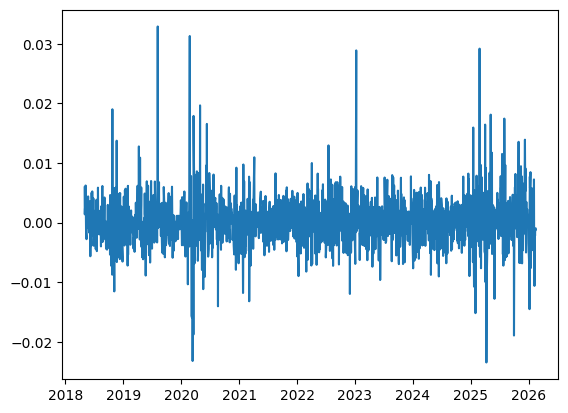

In [29]:
signal_df['signal'].groupby(signal_df.index.date).last().plot()

In [30]:
ls ../data/processed/futures_only_signal/

'ticker=AEG'/   'ticker=DEO'/   'ticker=ING'/   'ticker=PUK'/    'ticker=SONY'/
'ticker=ARGX'/  'ticker=E'/     'ticker=LYG'/   'ticker=RELX'/   'ticker=TAK'/
'ticker=ASML'/  'ticker=EQNR'/  'ticker=MFG'/   'ticker=RIO'/    'ticker=TM'/
'ticker=AZN'/   'ticker=ERIC'/  'ticker=MUFG'/  'ticker=RTO'/    'ticker=TS'/
'ticker=BBVA'/  'ticker=FMS'/   'ticker=NGG'/   'ticker=RYAAY'/  'ticker=TTE'/
'ticker=BCS'/   'ticker=GMAB'/  'ticker=NOK'/   'ticker=SAN'/    'ticker=UBS'/
'ticker=BHP'/   'ticker=GSK'/   'ticker=NVO'/   'ticker=SAP'/    'ticker=UL'/
'ticker=BP'/    'ticker=HLN'/   'ticker=NVS'/   'ticker=SHEL'/   'ticker=VOD'/
'ticker=BTI'/   'ticker=HMC'/   'ticker=NWG'/   'ticker=SMFG'/   'ticker=WDS'/
'ticker=BUD'/   'ticker=HSBC'/  'ticker=PHG'/   'ticker=SNN'/    'ticker=WPP'/
'ticker=DB'/    'ticker=IHG'/   'ticker=PSO'/   'ticker=SNY'/


KeyError: 'date'

In [ ]:
trade_df[(trade_df['ticker']=='GSK') & (trade_df['timestamp'].dt.strftime('%Y-%m-%d')=='2024-10-09')]

,timestamp,ticker,size,price,date
101288,2024-10-09 14:00:00+00:00,GSK,-35726,40.985,2024-10-09
101289,2024-10-09 16:00:00+00:00,GSK,35726,40.240,2024-10-09


0.48791435368754954

/tmp/ipykernel_806957/2491717829.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sign_df = open_df.pivot(index='date', columns='ticker', values='sign').fillna(0).astype(int)


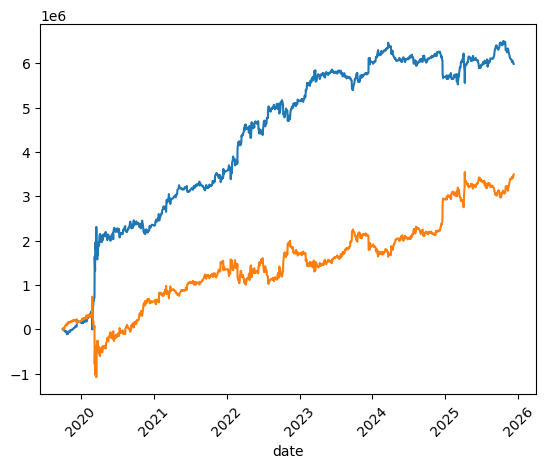

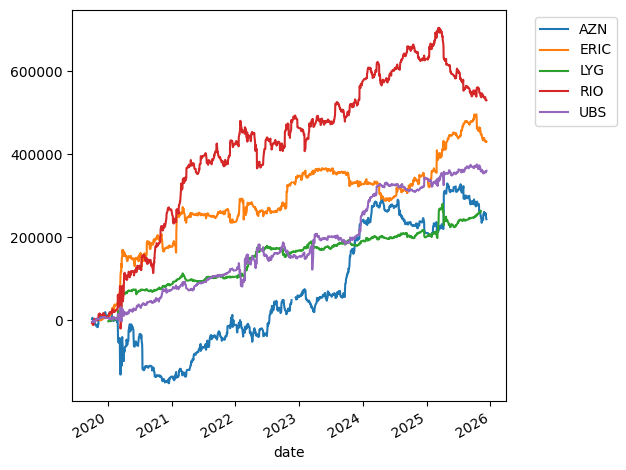

In [66]:
by_ticker[['AZN','ERIC','LYG','RIO','UBS']].cumsum().plot()
#plt.ylim([-500000,500000])
# putting legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

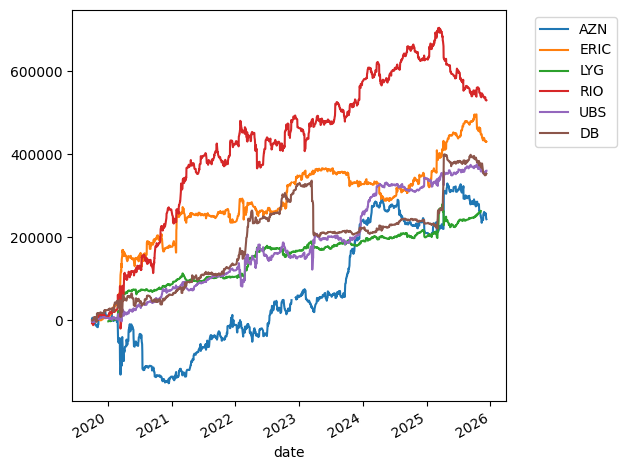

In [67]:
by_ticker[['AZN','ERIC','LYG','RIO','UBS','DB']].cumsum().plot()
#plt.ylim([-500000,500000])
# putting legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [ ]:
ticker = 'DB'
db_df = pd.read_parquet('../data/raw/adrs/bbo-1m/nbbo/ticker=DB')
db_df.loc['2025-10-09 13:30:00'][['nbbo_bid','nbbo_ask','nbbo_bid_sz','nbbo_ask_sz']]

nbbo_bid       35.04
nbbo_ask       35.05
nbbo_bid_sz     1500
nbbo_ask_sz      441
Name: 2025-10-09 13:30:00-04:00, dtype: object

In [ ]:
ret_sign = trade_df.sort_values('timestamp').groupby(['date','ticker'])['price'].apply(lambda x: np.sign(x.iloc[-1]-x.iloc[0]))
trade_sign = np.sign(trade_df.sort_values('timestamp').groupby(['date','ticker'])['size'].first())
trade_sign

date        ticker
2023-07-20  AEG      -1
            ARGX      1
            ASML      1
            AZN       1
            BBVA     -1
                     ..
2025-11-04  TS       -1
            TTE       1
            UL       -1
            VOD       1
            WPP       1
Name: size, Length: 22150, dtype: int64

0.5110609480812641